In [30]:
import pandas as pd
import numpy as np
from math import radians, cos, sin, asin, sqrt
from colour import Color
from scipy.sparse.csgraph import connected_components
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.linear_model import LinearRegression
#Some global parameters:
#Minimum number of tornados in each cluster
numt=2

#Radius of the tornadoes for F1 and higher and for F2 and higher (in km):
radF1=40

F1_plus={'EF1','EF2','EF3','EF4','EF5','F1','F2','F3','F4','F5'}
F2_plus=F1_plus-{"EF1",'F1'}
F3_plus=F2_plus-{'EF2','F2'}
F4_plus=F3_plus-{'EF3','F3'}
F5=F4_plus-{'EF4','F4'}

In [31]:
    #Import data
    data_file= pd.read_csv('../StormEvents_details_WORKING.csv')

In [32]:
#Define a function that takes a tornado data , sort them by the date, checks if the torandoes appear in the prescribed radius and are of the same type
# and returns only those that form a  cluster 

def clust(data,type,radius):
    #Create outcome Dataframe 
    clusters=pd.DataFrame()
    
    # First sort  by the same date and delete those groups that have < numt torandoes 

    gr=data.groupby(["BEGIN_YEARMONTH","BEGIN_DAY"]).groups
    for k,v in gr.copy():
       if len(gr[k,v]) <numt:
          del gr[k,v]


    for y,d in gr:
# Form a group of the tornadoes that happen in the same day 
        mini=data.loc[gr[y,d]]
            
    
    # Introduce the adjacency matrix and  some distances 
    
        
        adj=np.zeros((len(mini),len(mini)))
        dist1=np.zeros((len(mini),len(mini)))
        ind=[]
        for  i in range(len(mini)):
          for k in range(i+1,len(mini)):
    # converting lat and lon distnces in km 
               lat1=radians(mini['BEGIN_LAT'].iloc[i])
               lat2=radians(mini['BEGIN_LAT'].iloc[k])
               dlat=lat1-lat2
               dlon=radians(mini['BEGIN_LON'].iloc[i]-mini['BEGIN_LON'].iloc[k])
                
    # calculating distnce using  lat, lon and converting to  km
    # https://www.geeksforgeeks.org/program-distance-two-points-earth/
            
               distance = 2*6367*asin(sqrt(sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2))//1
              
    
    #form a matrix of 0 and 1 with rows and columns are tornadoes from the group
    #with i,j entry = 1   if torando i and tornado j happen within the prescribed radius  and if they are in F1_plus group  :
               if  (distance< radius) and (mini['TOR_F_SCALE'].iloc[i] in type) and (mini['TOR_F_SCALE'].iloc[k] in type)  :
                 adj[i,k]=1
    
        
    # find the conneced components of the graph with adjacency matrix = adj    =    finding which tornadoes form a cluster  
        con_comp=connected_components(adj)
        
    
        
    #create a "cluster" group column 
        mini['cluster'] = np.nan
        for a,b in enumerate(con_comp[1]):
            mini.iloc[a,-1]=b*0.00001 # mini['BEGIN_EARMONTH'].iloc[a]*100+b*0.0001
        
    
# consider only clusters that  have more then numt tornadoes inside 
        new_cluster=mini[mini.groupby('cluster')['cluster'].transform('size') >= numt]
        new_cluster.iloc[:,-1]=new_cluster.iloc[:,-1] +y*100+d
 
        clusters = pd.concat([clusters, new_cluster], ignore_index = False)


    return clusters

In [33]:
#Building clusters from the data
Clust_F1=clust(data_file,F1_plus,radF1)

In [34]:
# adding casualties and datetime

data_file['casualties']=data_file['INJURIES_DIRECT']+data_file['INJURIES_INDIRECT']+data_file['DEATHS_DIRECT']+data_file['DEATHS_INDIRECT']
Clust_F1['casualties']=Clust_F1['INJURIES_DIRECT']+Clust_F1['INJURIES_INDIRECT']+Clust_F1['DEATHS_DIRECT']+Clust_F1['DEATHS_INDIRECT']

BEGIN_DATE = []
  
for i in Clust_F1.index:
    y=Clust_F1["BEGIN_YEARMONTH"][i]//100
    m=Clust_F1["BEGIN_YEARMONTH"][i]%100
    BEGIN_DATE.append(pd.to_datetime(str(y)+'-'+str(m)+'-'+str(Clust_F1["BEGIN_DAY"][i])))

    
Clust_F1.insert(1, "BEGIN_DATE", BEGIN_DATE, True)

In [35]:
# some statistics 


def mean_LatLon(cluster,year_beg,year_end):
    df=pd.DataFrame(columns = ['Year','Mean_LAT', 'Mean_LON','Tot_tornadoes','Tot_casualties'])
    for  y in range(year_beg,year_end+1):  
       Num_Tot=len(cluster.loc[cluster['cluster']//10000  ==y ])
       Mean_LAT= cluster.loc[cluster['cluster']//10000  ==y ,'BEGIN_LAT'].mean()
       Mean_LON=cluster.loc[cluster['cluster']//10000  ==y ,'BEGIN_LON'].mean()
       Tot_cas=cluster.loc[cluster['cluster']//10000  ==y, 'casualties' ].sum()

       
       df.loc[-1] = [y, Mean_LAT, Mean_LON,Num_Tot, Tot_cas]
       df.index=df.index+1
    return  df.sort_values(by=['Year'])

In [36]:
MeanF1=mean_LatLon(Clust_F1,1950,2023)
MeanF1.head()

,Year,Mean_LAT,Mean_LON,Tot_tornadoes,Tot_casualties
73,1950.0,35.151754,-92.844211,57.0,330.0
72,1951.0,36.873571,-93.305000,42.0,63.0
71,1952.0,36.308202,-89.127978,89.0,1822.0
70,1953.0,37.853931,-91.367655,145.0,2199.0
69,1954.0,36.194258,-91.716968,155.0,469.0


In [37]:
skl=LinearRegression()
skl_Torbyyear=skl.fit(MeanF1['Year'].values.reshape(-1,1),MeanF1['Tot_tornadoes'])
skl.coef_[0]

4.6230136986301344

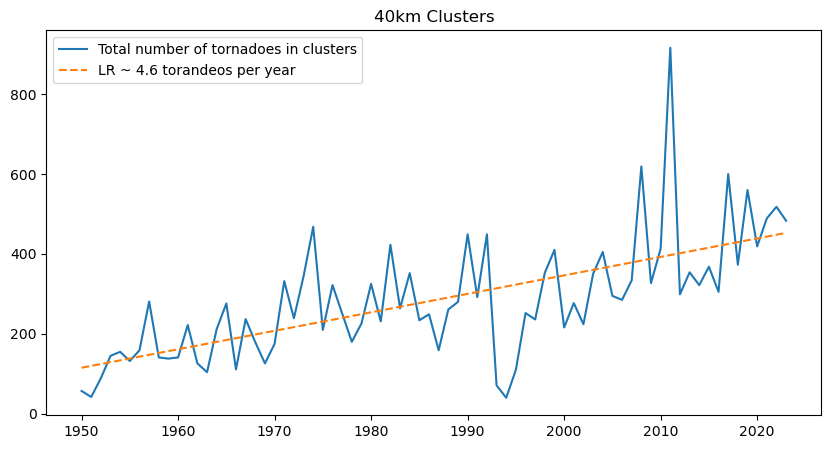

In [39]:
plt.figure(figsize=(10, 5))
plt.plot(MeanF1['Year'],MeanF1['Tot_tornadoes'], label='Total number of tornadoes in clusters')
plt.plot(MeanF1['Year'],skl.predict(MeanF1['Year'].values.reshape(-1,1)), label='LR ~ 4.6 torandeos per year',linestyle='--')
plt.legend()
plt.title('40km Clusters')
plt.savefig('../assets/Total number of tornadoes.png',bbox_inches='tight')
plt.show()

In [13]:

# Calculating total casualties by year from data:
years=np.arange(1950,2024)

Total_cas_by_year=[]

for y in years:
    Total_cas_by_year.append(sum(data_file.loc[data_file['BEGIN_YEARMONTH']//100 == y]['casualties']))

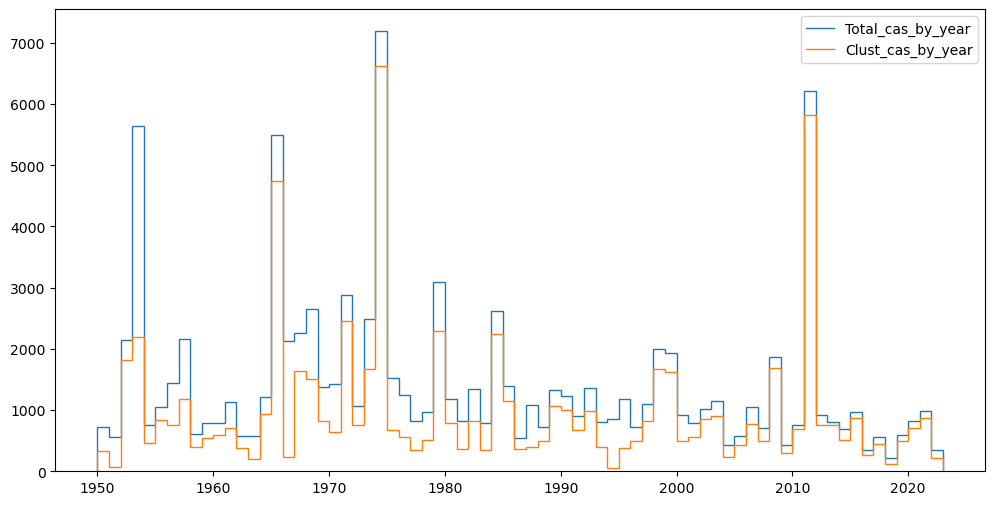

In [14]:
plt.figure(figsize=[12,6])
plt.stairs(Total_cas_by_year[:-1],years,label ='Total_cas_by_year')
plt.stairs(MeanF1['Tot_casualties'][:-1],years,label='Clust_cas_by_year')
plt.legend()
#plt.savefig('Total casualties.png',bbox_inches='tight')
plt.show()

In [15]:
Ratio=[ MeanF1['Tot_casualties'].iloc[i]/Total_cas_by_year[i]*100 for i in range(len(years))] 
skl_ratio=LinearRegression()
skl_ratio.fit(years.reshape(-1,1), Ratio)

LinearRegression()

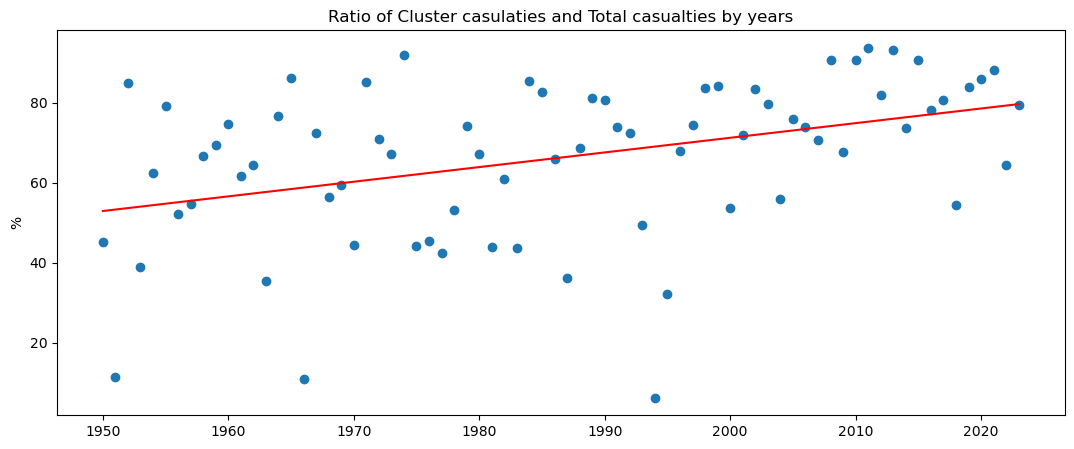

0.36650097922036134


In [16]:
plt.figure(figsize=[13,5])
plt.scatter(years, Ratio)
plt.title('Ratio of Cluster casulaties and Total casualties by years') 
plt.plot(years,skl_ratio.predict(years.reshape(-1,1)),c='r')
plt.ylabel('%') 
plt.savefig('Ratio of total casualties(years).png',bbox_inches='tight')
plt.show()
print(skl_ratio.coef_[0])

 

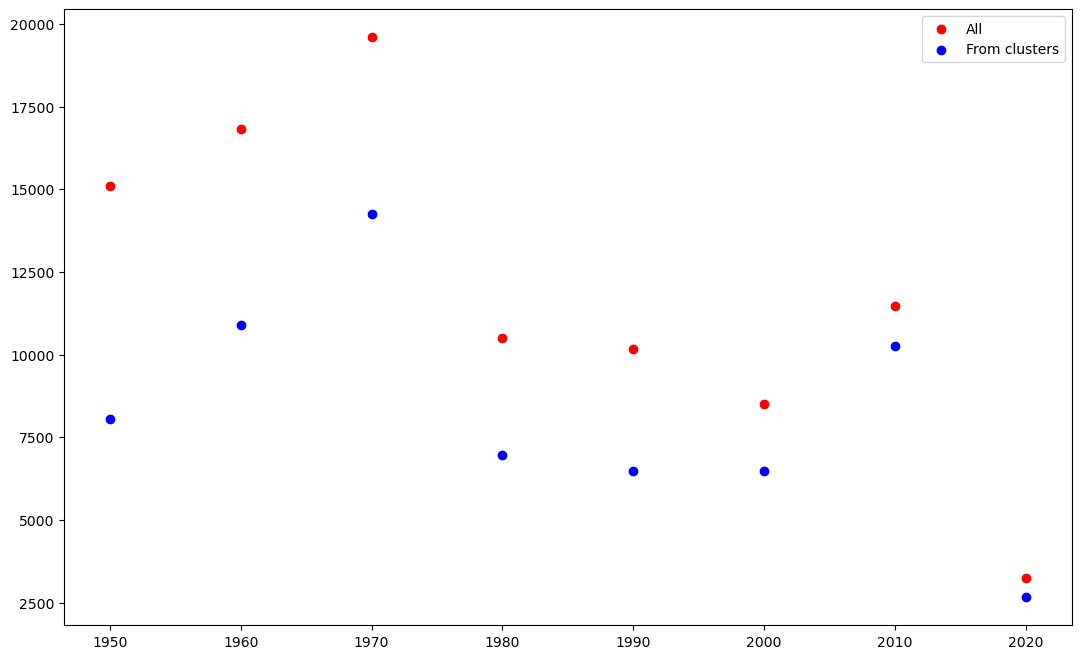

In [17]:
# the same but for decades

decades=np.arange(1950,2024,10)

Total_cas_by_decade=[]
Clust_cas_by_decade=[]
for y in range(195000,202412,1000):
    Total_cas_by_decade.append(sum(data_file.loc[data_file['BEGIN_YEARMONTH'].between(y,y+900)]['casualties']))
    Clust_cas_by_decade.append(sum(Clust_F1.loc[Clust_F1['BEGIN_YEARMONTH'].between(y,y+900)]['casualties']))

plt.figure(figsize=[13,8])
plt.scatter(decades, Total_cas_by_decade,c='r', label='All')
plt.scatter(decades, Clust_cas_by_decade,c='b', label='From clusters' )
plt.legend()
plt.savefig('Total casualties(decades).png',bbox_inches='tight')
plt.show()


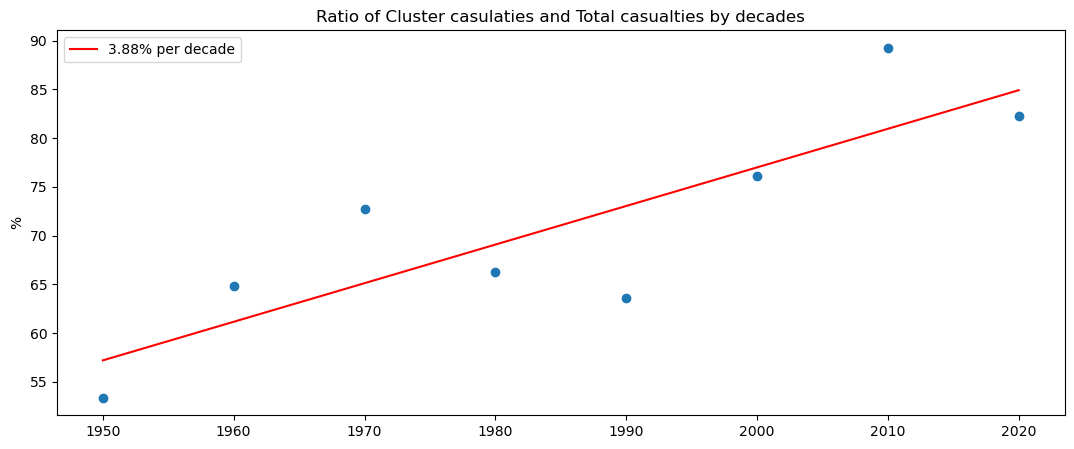

3.961745381939558

In [18]:
Ratio_d=[ Clust_cas_by_decade[i]/Total_cas_by_decade[i]*100 for i in range(len(decades))] 

skl_dec=LinearRegression()
skl_dec.fit(decades.reshape(-1,1),Ratio_d)

plt.figure(figsize=[13,5])
plt.scatter(decades, Ratio_d)
plt.title('Ratio of Cluster casulaties and Total casualties by decades') 
plt.ylabel('%') 
plt.plot(decades, skl_dec.predict(decades.reshape(-1,1)), c='r', label='3.88% per decade')
plt.legend()
plt.savefig('Ratio of  casualties(decades).png',bbox_inches='tight')
plt.show()

skl_dec.coef_[0]*10

In [19]:
#Some type statistics of tornadoes

def typestat(year, print_data=False):
    num_ofF1=0
    num_ofF2=0
    num_ofF3=0
    num_ofF4=0
    num_ofF5=0
    Num_tot=0
    for c in set(Clust_F1['cluster'].values):
        x=Counter(Clust_F1.loc[Clust_F1['cluster'].values==c,'TOR_F_SCALE'].values)
        
        if c//10000==year:
            Num_tot+=1
            num_ofF1=num_ofF1+x['F1']+x['EF1']
            num_ofF2=num_ofF2+x['F2']+x['EF2']
            num_ofF3=num_ofF3+x['F3']+x['EF3']
            num_ofF4=num_ofF4+x['F4']+x['EF4']
            num_ofF5=num_ofF5+x['F5']+x['EF5']
        
    if print_data:
       print('In', year,'Number of clusters with F1= ',num_ofF1,'Number of   clusters with F2= ',num_ofF2,'Number of   clusters with F3 = ',
          num_ofF3,'Number of   clusters  with F4= ',num_ofF4,'Number of  clusters with F5',num_ofF5,' Total clusters= ', Num_tot )
    return  [num_ofF1,num_ofF2,num_ofF3,num_ofF4,num_ofF5,Num_tot]

In [20]:
Type_data=pd.DataFrame(columns=["Year",'num_ofF1','num_ofF2','num_ofF3','num_ofF4','num_ofF5','Tot_num_of_cluster'])

for i in range(1950,2024):
     new_row=[i]+typestat(i)
     Type_data.loc[-1] = new_row # adding a row
     Type_data.index = Type_data.index + 1  # shifting index
Type_data = Type_data.sort_values(by=['Year'])
Type_data.head()

,Year,num_ofF1,num_ofF2,num_ofF3,num_ofF4,num_ofF5,Tot_num_of_cluster
73,1950,8,21,20,8,0,23
72,1951,8,19,13,2,0,20
71,1952,18,26,24,21,0,34
70,1953,31,42,36,31,5,58
69,1954,39,65,38,13,0,53


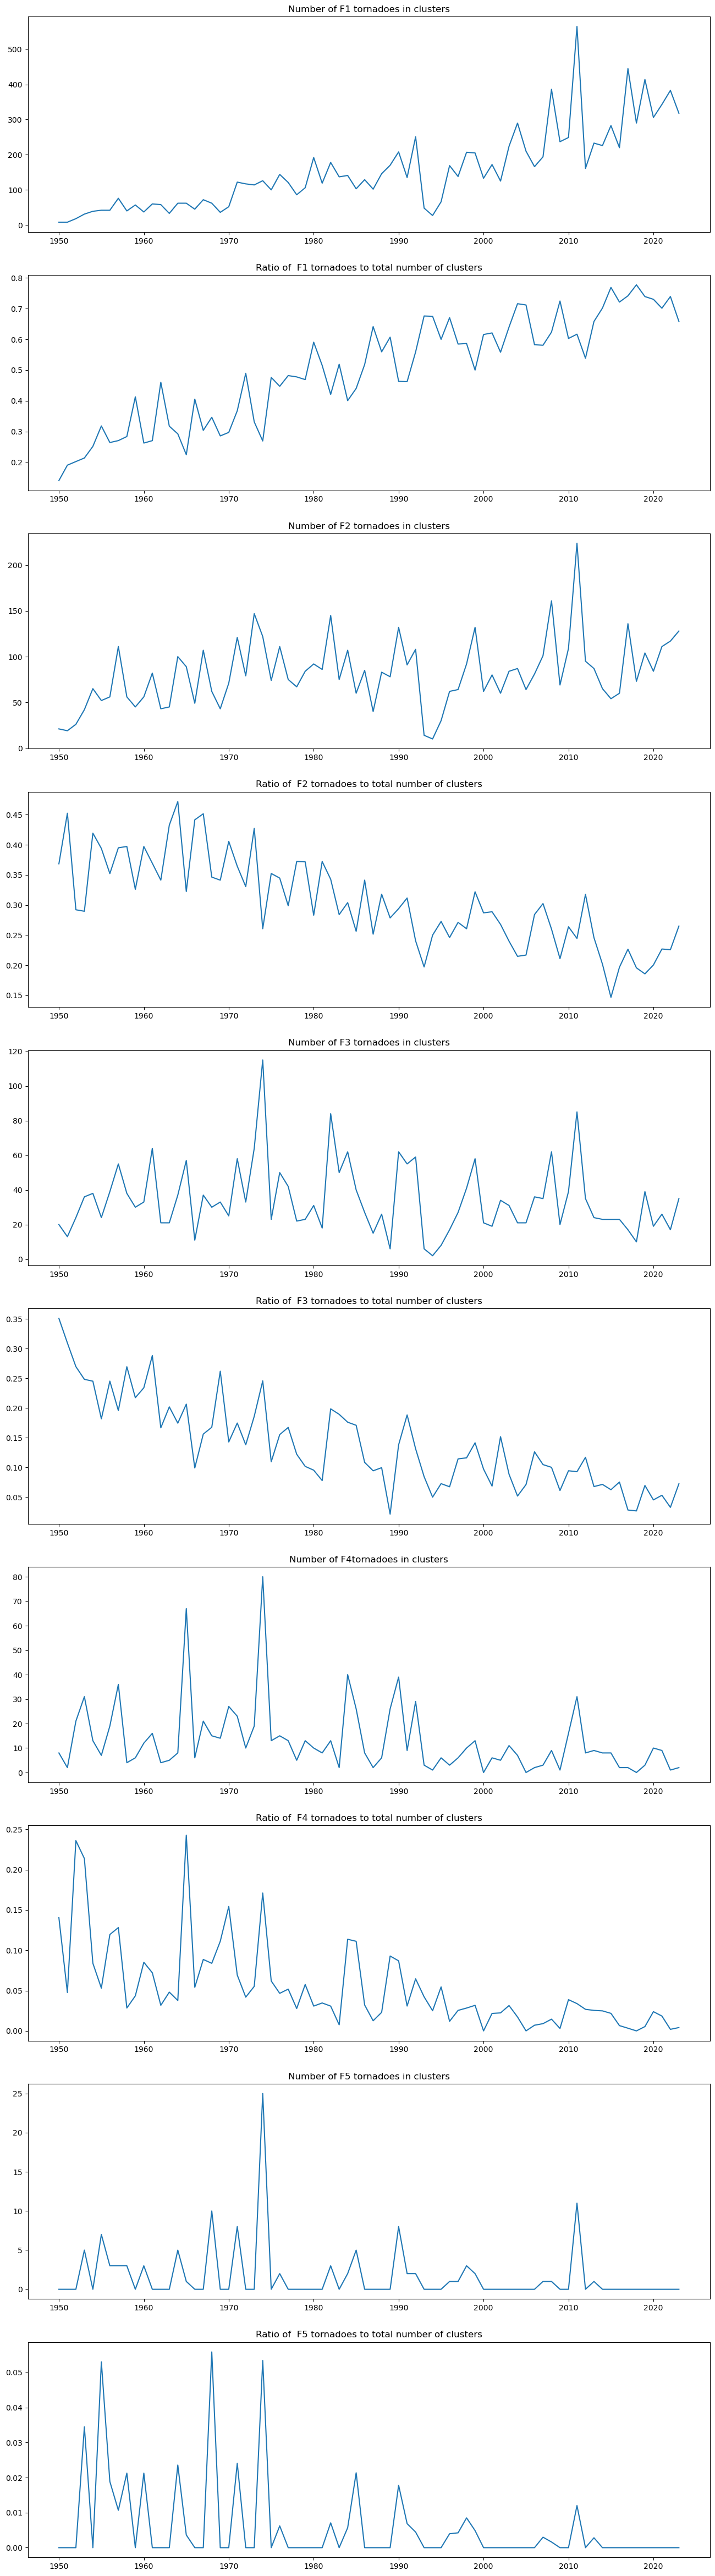

In [21]:
fig = plt.figure(figsize=[16,60])
ax1 = fig.add_subplot(10,1,1)
ax1.plot(np.arange(1950,2024),Type_data['num_ofF1'])
ax1.set_title('Number of F1 tornadoes in clusters')

ax2 = fig.add_subplot(10,1,2)
ax2.plot(np.arange(1950,2024),Type_data['num_ofF1']/MeanF1['Tot_tornadoes'])
ax2.set_title('Ratio of  F1 tornadoes to total number of clusters')

ax3 = fig.add_subplot(10,1,3)
ax3.plot(np.arange(1950,2024),Type_data['num_ofF2'])
ax3.set_title('Number of F2 tornadoes in clusters')

ax4 = fig.add_subplot(10,1,4)
ax4.plot(np.arange(1950,2024),Type_data['num_ofF2']/MeanF1['Tot_tornadoes'])
ax4.set_title('Ratio of  F2 tornadoes to total number of clusters')

ax5 = fig.add_subplot(10,1,5)
ax5.plot(np.arange(1950,2024),Type_data['num_ofF3'])
ax5.set_title('Number of F3 tornadoes in clusters')

ax6 = fig.add_subplot(10,1,6)
ax6.plot(np.arange(1950,2024),Type_data['num_ofF3']/MeanF1['Tot_tornadoes'])
ax6.set_title('Ratio of  F3 tornadoes to total number of clusters')

ax7 = fig.add_subplot(10,1,7)
ax7.plot(np.arange(1950,2024),Type_data['num_ofF4'])
ax7.set_title('Number of F4tornadoes in clusters')

ax8 = fig.add_subplot(10,1,8)
ax8.plot(np.arange(1950,2024),Type_data['num_ofF4']/MeanF1['Tot_tornadoes'])
ax8.set_title('Ratio of  F4 tornadoes to total number of clusters')

ax9 = fig.add_subplot(10,1,9)
ax9.plot(np.arange(1950,2024),Type_data['num_ofF5'])
ax9.set_title('Number of F5 tornadoes in clusters')

ax10 = fig.add_subplot(10,1,10)
ax10.plot(np.arange(1950,2024),Type_data['num_ofF5']/MeanF1['Tot_tornadoes'])
ax10.set_title('Ratio of  F5 tornadoes to total number of clusters')

plt.savefig('Type of clusters.png',bbox_inches='tight')

plt.show()

# Save the full figure...
#fig.savefig('full_figure.png')

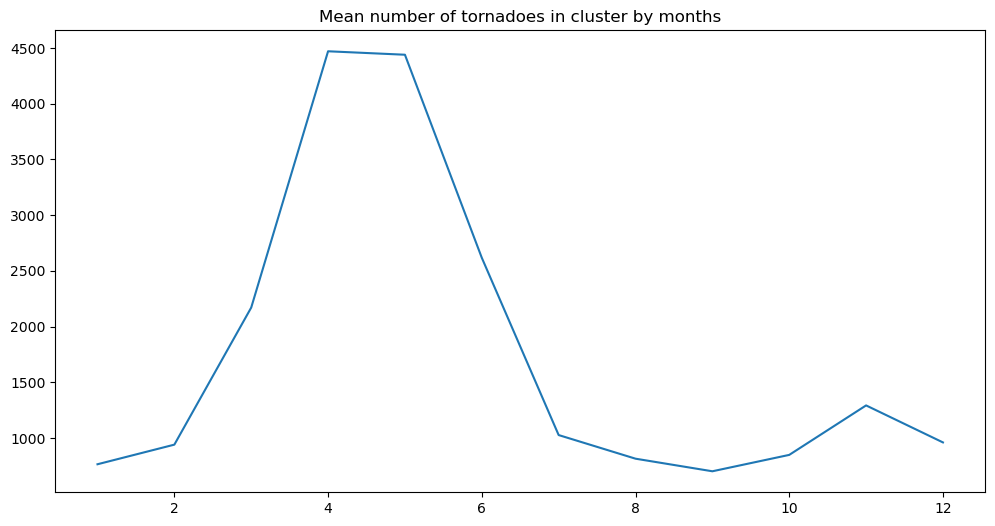

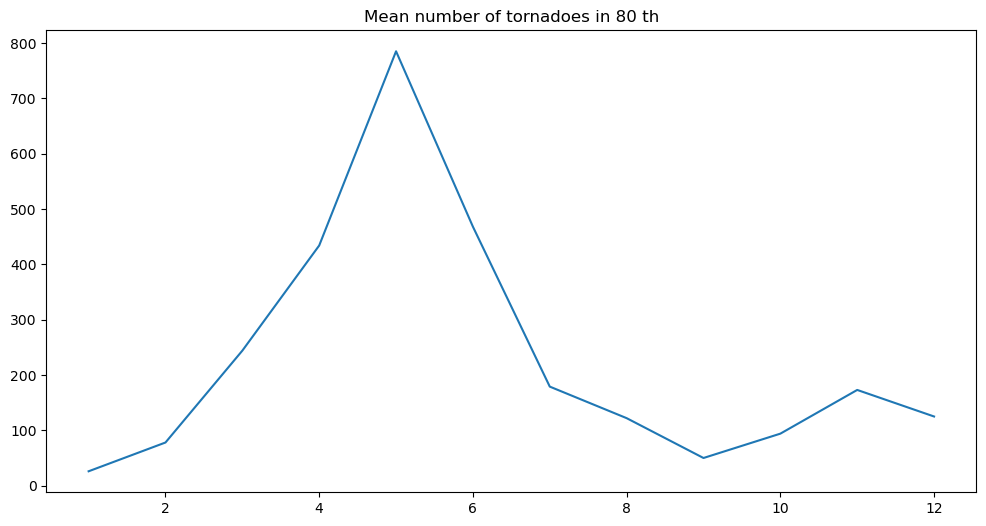

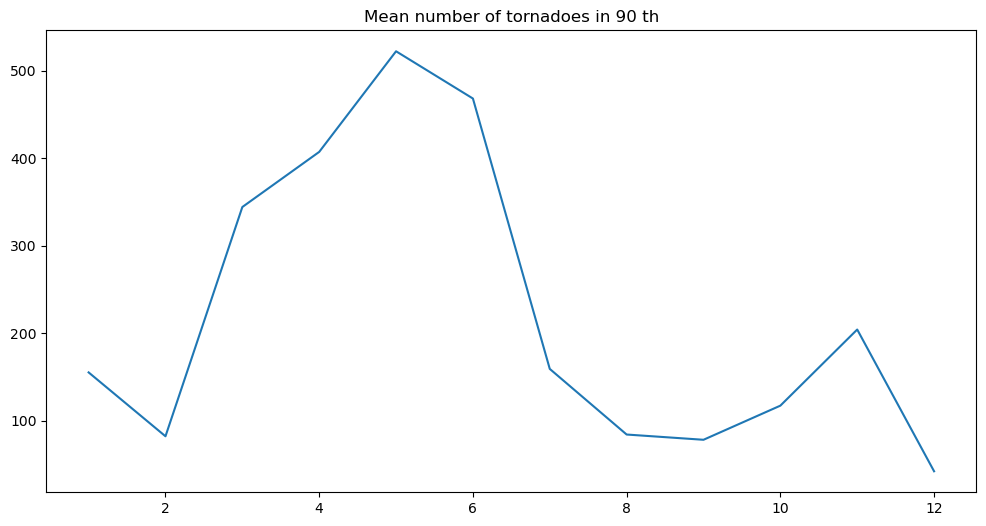

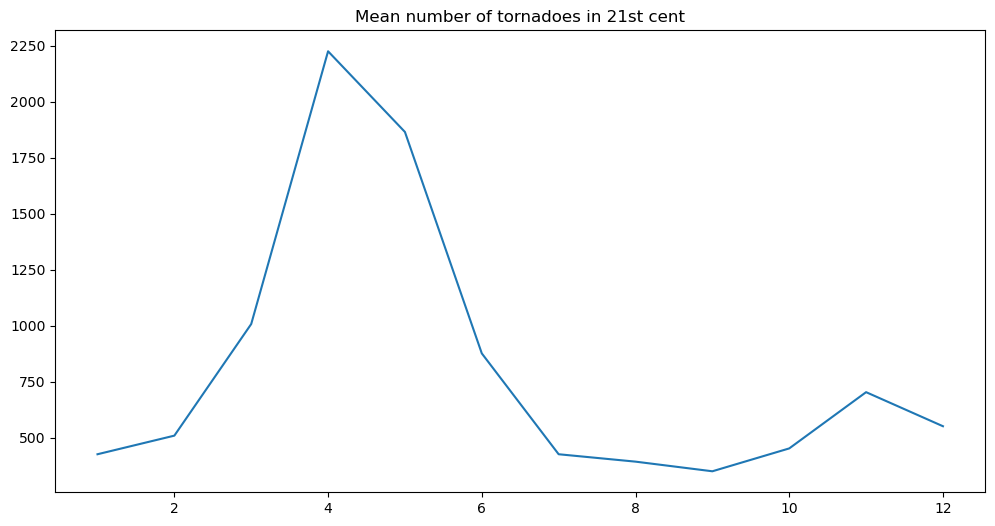

In [22]:
# Majority of clusters is happening in April_MAy 

months=np.arange(1,13)
[len(Clust_F1.loc[Clust_F1['BEGIN_YEARMONTH']%100==i]) for i in months]

plt.figure(figsize=[12,6])
plt.plot(months,[len(Clust_F1.loc[Clust_F1['BEGIN_YEARMONTH']%100==i]) for i in months])
plt.title('Mean number of tornadoes in cluster by months')

plt.figure(figsize=[12,6])
plt.plot(months,
         [len(  Clust_F1.loc[  (Clust_F1['BEGIN_YEARMONTH']%100==i) & (Clust_F1['BEGIN_YEARMONTH']//1000 == 198)   ]  ) for i in months])
plt.title('Mean number of tornadoes in 80 th')

plt.figure(figsize=[12,6])
plt.plot(months,
         [len(  Clust_F1.loc[  (Clust_F1['BEGIN_YEARMONTH']%100==i) & (Clust_F1['BEGIN_YEARMONTH']//1000 == 199)   ]  ) for i in months])
plt.title('Mean number of tornadoes in 90 th')

plt.figure(figsize=[12,6])
plt.plot(months,
         [len(  Clust_F1.loc[  (Clust_F1['BEGIN_YEARMONTH']%100==i) & (Clust_F1['BEGIN_YEARMONTH']//10000 == 20)   ]  ) for i in months])
plt.title('Mean number of tornadoes in 21st cent')

plt.savefig('Months.png',bbox_inches='tight')

plt.show()

In [23]:
MeanF1.head()

,Year,Mean_LAT,Mean_LON,Tot_tornadoes,Tot_casualties
73,1950.0,35.151754,-92.844211,57.0,330.0
72,1951.0,36.873571,-93.305000,42.0,63.0
71,1952.0,36.308202,-89.127978,89.0,1822.0
70,1953.0,37.853931,-91.367655,145.0,2199.0
69,1954.0,36.194258,-91.716968,155.0,469.0


In [24]:

Tot_Torn_bydecades=[]

x=MeanF1.groupby(MeanF1['Year']//10).groups 
for y in x.keys():
    print(y,MeanF1.loc[x[y]]['Tot_tornadoes'].sum())
    Tot_Torn_bydecades.append(MeanF1.loc[x[y]]['Tot_tornadoes'].sum())

195.0 1339.0
196.0 1734.0
197.0 2747.0
198.0 2778.0
199.0 2662.0
200.0 3332.0
201.0 4510.0
202.0 1909.0


In [25]:
Tot_Torn_bydecades

[1339.0, 1734.0, 2747.0, 2778.0, 2662.0, 3332.0, 4510.0, 1909.0]

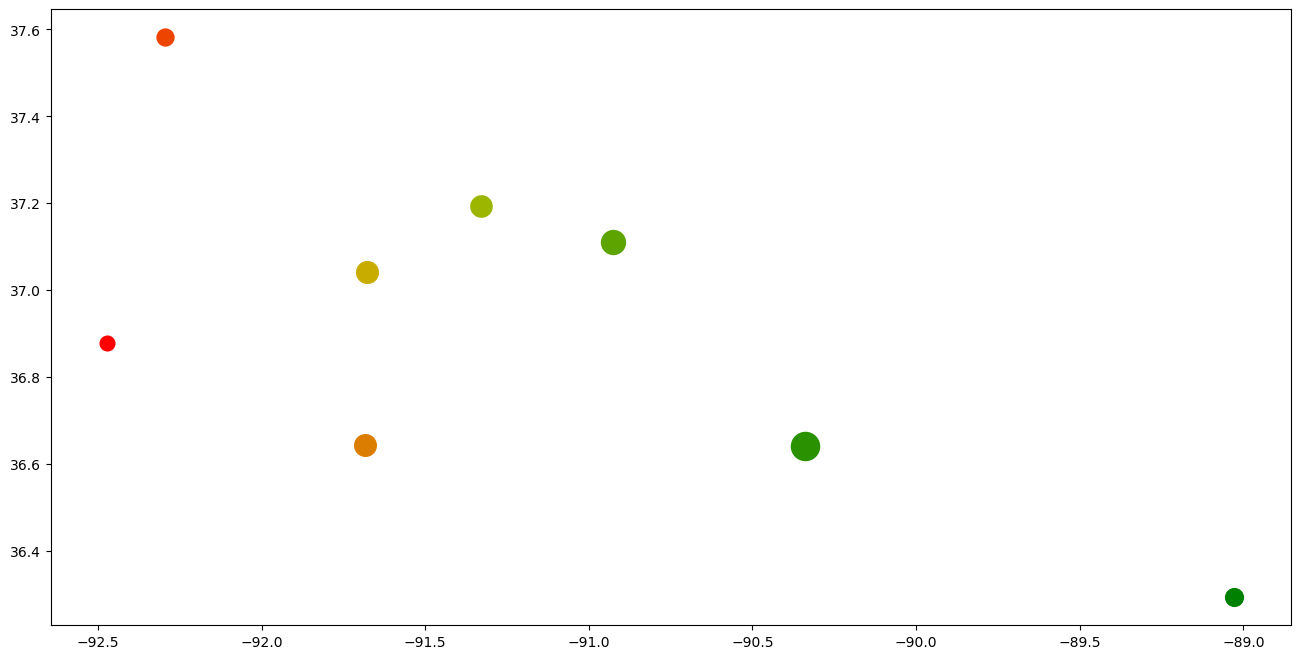

In [26]:
# Mean Lon/Lat by deacades:
Mean_by_deacades_LON=[]
Mean_by_deacades_LAT=[]
for y in decades[:-1]:
    Mean_by_deacades_LON.append(mean_LatLon(Clust_F1,y,y+10)['Mean_LON'].mean())
    Mean_by_deacades_LAT.append(mean_LatLon(Clust_F1,y,y+10)['Mean_LAT'].mean())
Mean_by_deacades_LON.append(mean_LatLon(Clust_F1,2020,2024)['Mean_LON'].mean())
Mean_by_deacades_LAT.append(mean_LatLon(Clust_F1,2020,2024)['Mean_LAT'].mean())

red = Color("red")
colors = list(red.range_to(Color("green"),len(decades)))

plt.figure(figsize=[16,8])   
for n,y in enumerate(decades):

 
     
    plt.scatter(Mean_by_deacades_LON[n],
              Mean_by_deacades_LAT[n],
                c = str(colors[n]), 
                s= Tot_Torn_bydecades[n]/10, 
                linewidth = 0) 
    
plt.savefig('SE shift(decades).png',bbox_inches='tight')
plt.show()

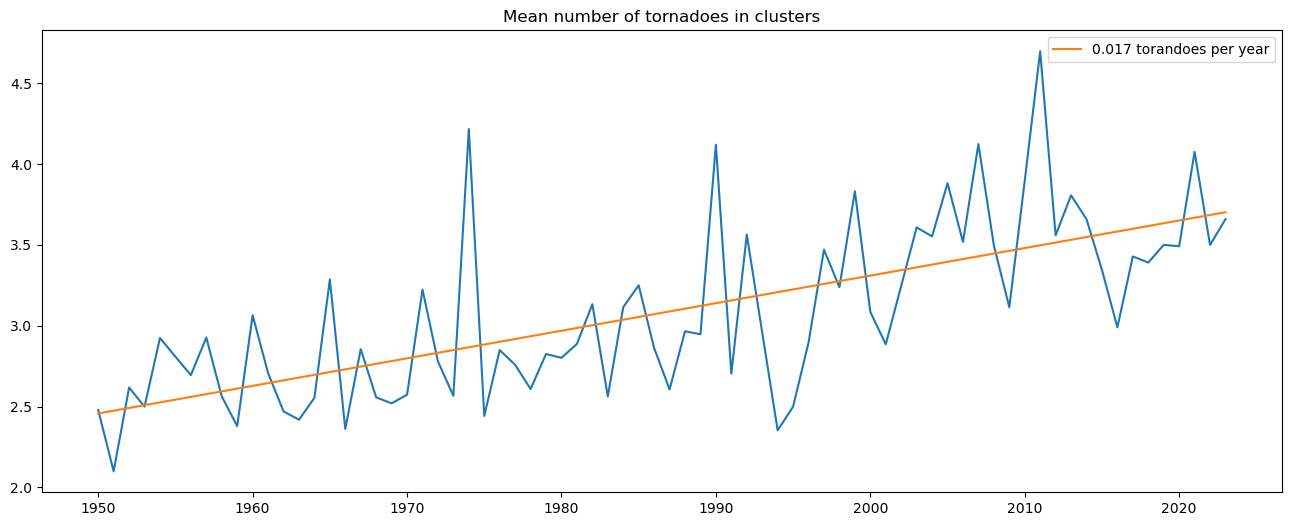

0.017044391651649084

In [27]:
r=Type_data[Type_data.columns[1:-1]].sum(axis='columns')/Type_data['Tot_num_of_cluster']

skl.fit(Type_data['Year'].values.reshape(-1,1),r)


plt.figure(figsize=[16,6])
plt.plot(Type_data['Year'],r)
plt.plot(Type_data['Year'],skl.predict(Type_data['Year'].values.reshape(-1,1)), label='0.017 torandoes per year')
plt.title("Mean number of tornadoes in clusters")
plt.legend()
plt.savefig('Size of clusters.png',bbox_inches='tight')
plt.show()

skl.coef_[0]

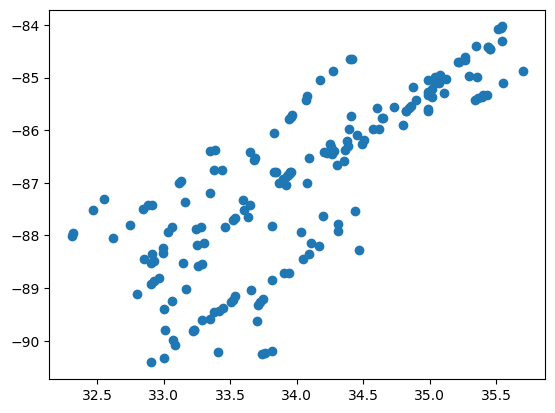

In [28]:
plt.scatter(Clust_F1[Clust_F1.cluster==20110427.00003]['BEGIN_LAT'],Clust_F1[Clust_F1.cluster==20110427.00003]['BEGIN_LON'])
plt.savefig('Huge cluster.png',bbox_inches='tight')
plt.show()